In [1]:
import sys
import os

# Standard modules used through the notebook 
import numpy as np
import matplotlib.pyplot as plt

# Tools specific for this tutorial
# They are in the .py files accompaining this notebook 
import ba_utils               # bundle adjustment tools
import vistools               # display tools
import utils                  # IO tools
import srtm4                  # SRTM tools
import rectification          # rectification tools
import stereo                 # stereo tools
import triangulation          # triangulation tools
from vistools import printbf  # boldface print

import ortographic

# Display and interface settings (just for the notebook interface)
%load_ext autoreload
%autoreload 2
%matplotlib inline
np.set_printoptions(linewidth=150)

### Load data and set AOI

Found 4 images
Number of images to be used: 4
Finished loading RPC coefficients
Finished cropping the AOI in each image



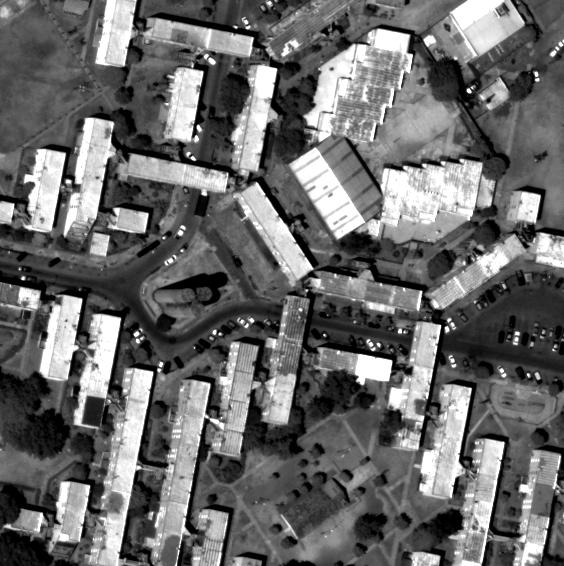
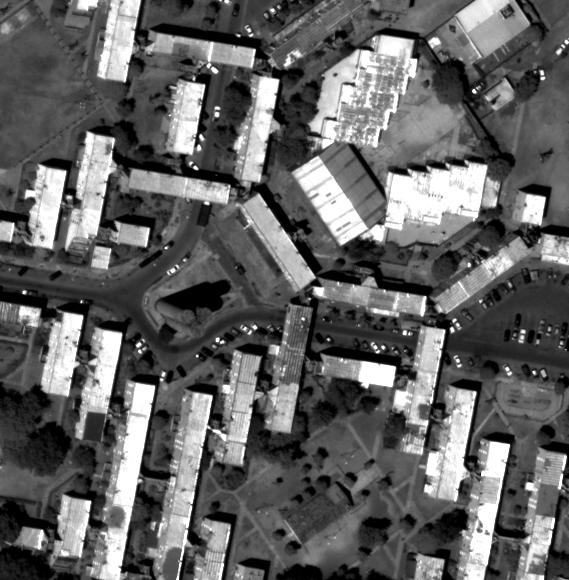
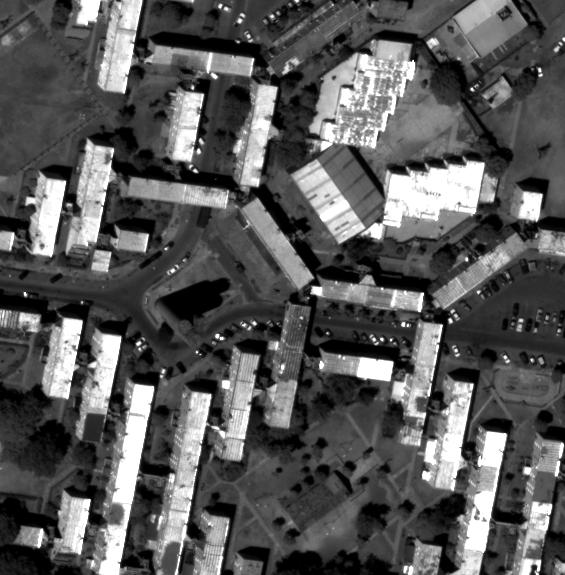
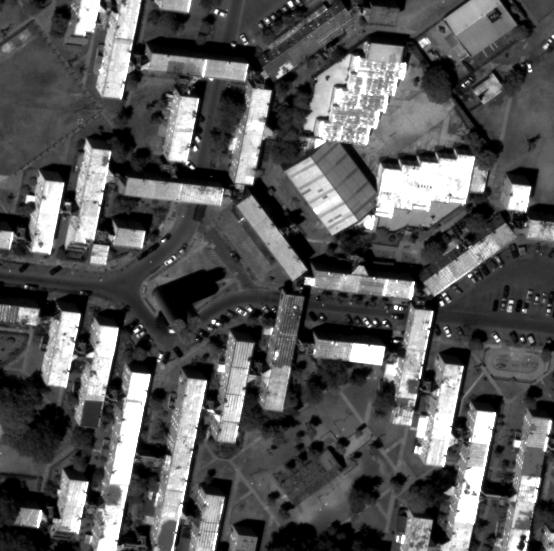

In [2]:
# list the tiff images available in the remote folder
IARPAurl = 'http://menthe.ovh.hw.ipol.im:80/IARPA_data/cloud_optimized_geotif'
myimages = utils.listFD(IARPAurl, 'TIF')

# sort the images by acquisition date
myimages = sorted(myimages, key=utils.acquisition_date)
myimages.pop(11)
myimages.pop(13)
myimages.pop(19)
myimages = myimages[36:40] # we pick only 4 optimal images for this experiment
print('Found {} images'.format(len(myimages)))

# select the number of cameras for the current run
n_cam = len(myimages)
print('Number of images to be used:', n_cam)

# load RPC coefficients
myrpcs = [utils.rpc_from_geotiff(x) for x in myimages]
print('Finished loading RPC coefficients')

# set the coordinates of the area of interest as a GeoJSON polygon (Buenos aires AOI)
aoi_buenos_aires = {'coordinates': [[[-58.585185, -34.490883], [-58.585185, -34.48922 ], [-58.583104, -34.48922 ],
                                     [-58.583104, -34.490883], [-58.585185, -34.490883]]], 'type': 'Polygon'}
aoi_buenos_aires['center'] = np.mean(aoi_buenos_aires['coordinates'][0][:4], axis=0).tolist() # add center field

# get the altitude of the center of the AOI
lon, lat = aoi_buenos_aires['center']
z = srtm4.srtm4(lon, lat)

# crop the selected AOI in each image
mycrops, im = [], []
for f in range(len(myimages)):
    crop, x0, y0 = utils.crop_aoi(myimages[f], aoi_buenos_aires, z)
    mycrops.append({ 'crop': utils.simple_equalization_8bit(crop), 'x0': x0, 'y0': y0 })
    im.append(utils.simple_equalization_8bit(crop))
print('Finished cropping the AOI in each image')
vistools.display_gallery(im)

### Create complete feature tracks 

- Only those tracks with the same length as the number of images are preserved

In [44]:
# $ pip3 install opencv-python==3.4.0.12 opencv-contrib-python==3.4.0.12
# otherwise sift might not work
import cv2

'''
FEATURE TRACKS REPRESENTATION
'feature_tracks': (track_id, (x,y), cam_id) --> (x, y) = coord of the 3D point of 'track_id' projected in 'cam_id'
'r':              (track_id, cam_id) --> sparse matrix, r[track_id, cam_id] =1 if the 3D point is seen in 'cam_id'
'''

# (1) detect SIFT keypoints
features = []
for f in range(len(mycrops)):
    kp, des = ba_utils.find_SIFT_kp(mycrops[f]['crop'])
    features.append({ 'kp': kp, 'des': des })
    #im_kp=cv2.drawKeypoints(mycrops[f]['crop'],kp,outImage=np.array([]))
    #vistools.display_image(im_kp)

# (1) create feature tracks
tracks_id, feature_tracks, r = 0, np.zeros((1, 2, n_cam)), np.zeros((1, n_cam))
for i in range(n_cam):
    kp_i, des_i = features[i]['kp'], features[i]['des']
    for j in range(i+1,n_cam):
        kp_j, des_j = features[j]['kp'], features[j]['des']
        pts_i, pts_j, kp_i, kp_j, m_filt, m_all = ba_utils.match_pair(kp_i, kp_j, des_i, des_j, 0.6) 
        n_matches = 0 if pts_i is None else pts_i.shape[0]
        print('Pair ({},{}) -> {} matches'.format(i,j,n_matches))
               
        # display matches for pair (i,j)
        #im_matches = cv2.drawMatches(mycrops[i]['crop'],kp_i,mycrops[j]['crop'],kp_j,m_filt,outImg=np.array([]))
        #vistools.display_imshow(utils.simple_equalization_8bit(im_matches))

        # if point i belongs to an existing track, then add point j... else, create new track
        for k in range(n_matches):
            xi, yi = pts_i[k,:]
            xj, yj = pts_j[k,:]
            list_of_existing_tracks_in_i = feature_tracks[:,:,i].tolist()
            if [xi, yi] in list_of_existing_tracks_in_i:
                existing_track_id = list_of_existing_tracks_in_i.index([xi, yi])
                feature_tracks[existing_track_id,:,j] = [xj, yj]
                r[existing_track_id,i], r[existing_track_id,j] = 1, 1
            else:
                tracks_id += 1
                new_track = np.zeros((1,2,n_cam))
                new_track[:,:,i], new_track[:,:,j]  = [xi, yi], [xj, yj]
                tmp = np.zeros((1,n_cam))
                tmp[:,i], tmp[:,j] = 1, 1
                feature_tracks, r = np.vstack((feature_tracks, new_track)), np.vstack((r, tmp))

feature_tracks, r = feature_tracks[1:,:,:], r[1:,:]
n_pts = feature_tracks.shape[0]
print('\nFound', n_pts, 'feature tracks.\n')

Pair (0,1) -> 813 matches
Pair (0,2) -> 235 matches
Pair (0,3) -> 121 matches
Pair (1,2) -> 961 matches
Pair (1,3) -> 433 matches
Pair (2,3) -> 1211 matches

Found 1990 feature tracks.



In [45]:
# preserve only those track with one observation per image

tracks_len = np.sum(r,1)
for current_len in range(2,n_cam+1):
    print('Feature tracks of length {}: {}'.format(current_len, np.count_nonzero(tracks_len == current_len)))

complete_tracks, complete_r = [], []
for a in range(tracks_len.shape[0]):
    if int(tracks_len[a]) == n_cam:
        complete_tracks.append(feature_tracks[a,:])
        complete_r.append(r[a,:])
        
complete_tracks = np.array(complete_tracks)
complete_r = np.array(complete_r)

print(complete_tracks.shape)

Feature tracks of length 2: 1242
Feature tracks of length 3: 499
Feature tracks of length 4: 249
(249, 2, 4)


In [46]:
Corresp = ba_utils.corresp_matrix_from_tracks(complete_tracks,complete_r)
np.savetxt('ba_experiments/complete_tracks_ortographic.txt', Corresp, delimiter = ' ')

C = np.loadtxt('ba_experiments/complete_tracks_ortographic.txt')

print(C.shape)

(8, 249)


### Set calibration matrix for scaled-ortographic pose estimation factorization algorithm

In [47]:
#WorldView-3
pxResolution = 0.31 # in meters
orbitAlt = 617000   # in meters
focalLm = 13.3      # in meters
pxSize = focalLm/orbitAlt * pxResolution # in meters (per pixel)

# https://www.harrisgeospatial.com/docs/ParametersForDigitalCamerasPushbroomSensors.html
# https://directory.eoportal.org/web/eoportal/satellite-missions/v-w-x-y-z/worldview-2
# https://directory.eoportal.org/web/eoportal/satellite-missions/v-w-x-y-z/worldview-3

# compute focal length in pixels
focalLpx = focalLm / pxSize

# get principal points
images_size = np.array([np.flip(image['crop'].shape, axis=0) for image in mycrops]).ravel()
print(images_size)

# build calibration matrix
CalM=np.tile([[focalLpx,0,0],[0,focalLpx,0],[0,0,1]],(n_cam,1))
CalM[np.setdiff1d(np.arange(n_cam*3), 3*np.arange(1,n_cam+1)-1),2] = images_size/2.

print('Built Calibration matrix.')

Built Calibration matrix.


### Ortographic pose estimation

- Use the factorization algorithm to initialize the position of the cameras

In [48]:
# AC-RANSAC with Orthographic model
imsize = np.inf
for image in mycrops:
    if np.prod(np.shape(image['crop'])) < imsize:
        imsize = np.prod(np.shape(image['crop']))

Corresp = C
inliers, Sol, ransac_th = ortographic.ac_ransac_orthographic(Corresp,CalM,np.prod(imsize))
print('{} tracks between the three images.'.format(Corresp.shape[1]));
print('{} inliers were found by AC-RANSAC.'.format(inliers.shape[1]))

inliers = np.sort(inliers)
Corresp = Corresp[:,inliers.ravel()]

# Orthographic model
sol1, sol2 = ortographic.ortographic_pose_estimation(Corresp, CalM)
print('\nOrtographic Pose Estimation completed.')

/home/rogermm14/IS18/ortographic.py:206: RuntimeWarning: overflow encountered in double_scalars
  nosample = np.setdiff1d(np.arange(N),sample)
/home/rogermm14/IS18/ortographic.py:206: RuntimeWarning: invalid value encountered in double_scalars
  nosample = np.setdiff1d(np.arange(N),sample)


249 tracks between the three images.
249 inliers were found by AC-RANSAC.

Ortographic Pose Estimation completed.


### Define BA input parameters

In [49]:
'''
INPUT PARAMETERS FOR BUNDLE ADJUSTMENT
'cam_params': (n_cam, 6), initial projection matrices. 1 row = 1 camera estimate.
              first 3 elements of each row = R vector, next 3 = T vector, then f and ppoint
'pts_3d'    : (n_pts, 3) contains the initial estimates of the 3D points in the world frame.
'cam_ind'   : (n_observations,), indices of cameras (from 0 to n_cam - 1) involved in each observation.
'pts_ind'   : (n_observations,) indices of points (from 0 to n_points - 1) involved in each observation.
'pts_2d'    : (n_observations, 2) 2-D coordinates of points projected on images in each observations.
'''

cam_params_opt, cam_params, pts_2d, \
cam_ind, pts_ind, ba_params, pts_3d = ortographic.define_ba_params(sol1, Corresp, CalM)
cam_params_init, pts_3d_init = cam_params, pts_3d

print('pts_2d.shape:{}  pts_ind.shape:{}  cam_ind.shape:{}'.format(pts_2d.shape, pts_ind.shape, cam_ind.shape))
print('pts_3d.shape:{}  cam_params.shape:{}'.format(pts_3d.shape, cam_params.shape))
print('\nBundle Adjustment parameters defined')

pts_2d.shape:(996, 2)  pts_ind.shape:(996,)  cam_ind.shape:(996,)
pts_3d.shape:(249, 3)  cam_params.shape:(4, 9)

Bundle Adjustment parameters defined


### Run BA

Both camera parameters and 3D points will be optimized

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.6637e+06                                    5.10e+10    
       1              2         3.4962e+01      2.66e+06       2.21e-03       2.76e+06    
       2              3         3.4956e+01      5.52e-03       3.36e-07       4.07e+02    
`xtol` termination condition is satisfied.
Function evaluations 3, initial cost 2.6637e+06, final cost 3.4956e+01, first-order optimality 4.07e+02.
Optimization took 0 seconds


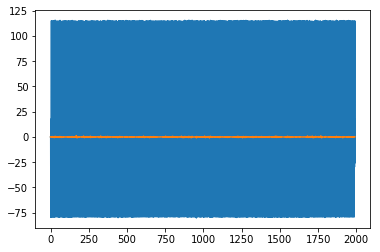

In [50]:
import time
from scipy.optimize import least_squares, minimize

# run BA
if ba_params['n_params'] > 0 and ba_params['opt_X']:
    print('Both camera parameters and 3D points will be optimized\n')
    x0 = np.hstack((cam_params_opt.ravel(), pts_3d.ravel()))
elif ba_params['n_params'] > 0 and not ba_params['opt_X']:
    print('Only the camera parameters will be optimized\n')
    x0 = np.hstack(cam_params_opt.ravel())
else:
    print('Only 3D points will be optimized\n')
    x0 = np.hstack(pts_3d.ravel())

# compute loss value and plot residuals at the initial parameters
f0 = ortographic.fun(x0, cam_ind, pts_ind, pts_2d, cam_params_init, pts_3d_init, ba_params)
plt.plot(f0)

# define jacobian
A = ortographic.bundle_adjustment_sparsity(cam_ind, pts_ind, ba_params)
#print('Shape of sparsity matrix:', A.shape)

# run bundle adjustment
t0 = time.time()
res = least_squares(ortographic.fun, x0, jac_sparsity=A, verbose=2, x_scale='jac',
                    ftol=1e-4, method='trf', #loss='soft_l1', f_scale = 5.0,
                    args=(cam_ind, pts_ind, pts_2d, cam_params_init, pts_3d_init, ba_params))

#res = minimize(ba_utils.fun, x0, args=(cam_ind, pts_ind, pts_2d, proper_R_axis, cam_params_init, pts_3d_init, ba_params), method='BFGS')
t1 = time.time()
print("Optimization took {0:.0f} seconds".format(t1 - t0))

#plot residuals at the found solution
plt.plot(res.fun);

# recover BA output
pts_3d_ba, cam_params_ba, P_crop_ba = ortographic.recover_ba_output(res.x, ba_params, cam_params_init, pts_3d_init)

Error before BA (mean / median): 68.53 / 66.70
Error after  BA (mean / median): 0.25 / 0.19


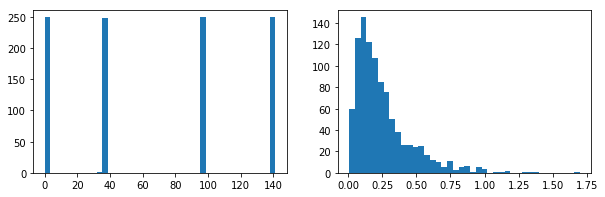

In [51]:
# BA error performance before getting rid of outlier observations

n_observations = pts_2d.shape[0]

init_e = np.sort(np.add.reduceat(abs(f0), np.arange(0, len(f0), 2)))
init_e_mean = np.mean(init_e)
init_e_median = np.median(init_e)

ba_e = np.sort(np.add.reduceat(abs(res.fun), np.arange(0, len(res.fun), 2)))
ba_e_mean = np.mean(ba_e)
ba_e_median = np.median(ba_e)

print('Error before BA (mean / median): {:.2f} / {:.2f}'.format(init_e_mean, init_e_median))
print('Error after  BA (mean / median): {:.2f} / {:.2f}'.format(ba_e_mean, ba_e_median))

_,f = plt.subplots(1, 2, figsize=(10,3))
f[0].hist(init_e, bins=40); 
f[1].hist(ba_e, bins=40); 

 ----> Real 2D loc in im 0  (sol) =  [  8.79663277 177.16584778]
 ----> Proj 2D loc in im 0  b. BA =  [  8.90389273 177.16382329]
 ----> Proj 2D loc in im 0  a. BA =  [  8.93791058 177.25312932]
 ----> Real 2D loc in im 1  (sol) =  [  9.9928627  192.30870056]
 ----> Proj 2D loc in im 1  b. BA =  [-69.62750848 209.95009786]
 ----> Proj 2D loc in im 1  a. BA =  [  9.67024094 192.17414651]
 ----> Real 2D loc in im 2  (sol) =  [ 10.61701298 198.87197876]
 ----> Proj 2D loc in im 2  b. BA =  [-19.23886934 205.11985883]
 ----> Proj 2D loc in im 2  a. BA =  [ 10.60520381 198.83752548]

Reprojection error b. BA:  4398.742048331728
Reprojection error b. BA:  0.26338931707012186


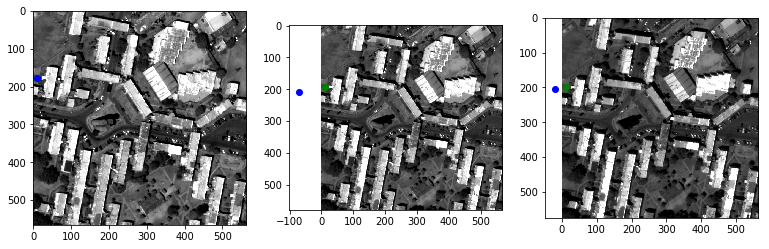

In [52]:
#display measured points vs projections

p_ind = 0
im_ind = [0,1,2]
reprojection_error, reprojection_error_ba  = 0., 0.
cont = -1
_,f = plt.subplots(1, len(im_ind), figsize=(13,10))

for i in im_ind:   
    cont += 1
    
    p_3d = pts_3d[p_ind,:]
    p_3d_ba = pts_3d_ba[p_ind,:]
    p_2d_gt = Corresp[(2*i):(2*i)+2,p_ind]
    
    p_2d_proj = ortographic.project(np.array([p_3d]),np.array([cam_params[i,:]])).ravel()
    p_2d_proj_ba = ortographic.project(np.array([p_3d_ba]),np.array([cam_params_ba[i,:]])).ravel()
    
    reprojection_error += np.sum(p_2d_proj - p_2d_gt) ** 2
    reprojection_error_ba += np.sum(p_2d_proj_ba - p_2d_gt) ** 2
    
    print(' ----> Real 2D loc in im', i, ' (sol) = ', p_2d_gt)
    print(' ----> Proj 2D loc in im', i, ' b. BA = ', p_2d_proj.ravel())
    print(' ----> Proj 2D loc in im', i, ' a. BA = ', p_2d_proj_ba.ravel())
    
    im = 255.*np.ones((1000,1000))
    #f[cont].imshow(im.squeeze(), cmap="gray", vmin=0, vmax=255)
    f[cont].imshow((mycrops[i]['crop']), cmap="gray")
    f[cont].plot(*p_2d_gt, "go")
    f[cont].plot(*p_2d_proj, "bo")
    
print('\nReprojection error b. BA: ', (reprojection_error))
print('Reprojection error b. BA: ', (reprojection_error_ba))

### Set output directory

In [53]:
# all outputs of the experiment will be saved in this directory

input_dir = 'ba_experiments/ortographic'

if not os.path.isdir(input_dir):
    os.mkdir(input_dir)

### Compute point clouds for all pairs

In [54]:
os.chdir('../s2p/')
from s2plib import geographiclib
os.chdir('../IS18/')

# get a dense point cloud for all possible pairs
list_of_pairs = [(0,1), (0,2), (0,3), (1,2), (1,3), (2,3)]

if not os.path.isdir(input_dir+'/clouds'):
    os.mkdir(input_dir+'/clouds')

cam_model = 'Perspective'
for pair in list_of_pairs:
    i, j = pair
    print('Pocessing pair ({},{})...'.format(i, j))
    cloud =  ba_utils.cloud_from_pair(i, j, P_crop_ba[i], P_crop_ba[j], cam_model, myimages, mycrops, aoi_buenos_aires)
    x , y, z = cloud[:,0], cloud[:,1], cloud[:,2]
    xyz = np.vstack((x, y, z)).T
    ba_utils.write_point_cloud_ply(input_dir+'/clouds/dense_cloud_{:02}_{:02}.ply'.format(i,j), xyz)
    print('Done!\n')

Pocessing pair (0,1)...
t=1.9526 done building CV
t=4.8806 done sgmfilter
t=5.0900 done aggregation and WTA refinement
t=1.9104 done building CV
t=4.9771 done sgmfilter
t=5.1930 done aggregation and WTA refinement
Done!

Pocessing pair (0,2)...
t=2.0021 done building CV
t=5.1501 done sgmfilter
t=5.3868 done aggregation and WTA refinement
t=1.8674 done building CV
t=5.1389 done sgmfilter
t=5.3814 done aggregation and WTA refinement
Done!

Pocessing pair (0,3)...
t=2.0530 done building CV
t=5.4105 done sgmfilter
t=5.6421 done aggregation and WTA refinement
t=1.9564 done building CV
t=5.1213 done sgmfilter
t=5.3495 done aggregation and WTA refinement
Done!

Pocessing pair (1,2)...
t=2.0168 done building CV
t=5.3252 done sgmfilter
t=5.5734 done aggregation and WTA refinement
t=1.9431 done building CV
t=4.9344 done sgmfilter
t=5.1658 done aggregation and WTA refinement
Done!

Pocessing pair (1,3)...
t=1.9655 done building CV
t=5.1566 done sgmfilter
t=5.4029 done aggregation and WTA refineme

### TO DO:

- Up until this point, the point clouds are computed and they look nice when visualized with meshlab.
- Problem: the factorization algorithm aligns the camera of reference with the origin of coordinates.
- In other words, the rotation of the first camera is the identity and its translation is a vector of zeros.
- Clouds should be reexpressed in geocentric coordinates so that camera of reference is not at the Earth origin.

In [55]:
# check that the camera of reference is indeed aligned with the origin of coordinates
P_ref = ortographic.ba_cam_params_to_P(cam_params[0,:])
_, R, T, _ = ba_utils.decompose_projection_matrix(P_ref)

print('Camera of reference was initialized with pose (R | T):')
print(np.around(np.hstack((R,np.expand_dims(T.T, axis=1)))))

Camera of reference was initialized with pose (R | T):
[[ 1. -0.  0. -0.]
 [ 0.  1. -0. -0.]
 [-0.  0.  1.  0.]]
